In [113]:
import pandas as pd 
monthly = pd.read_csv('monthly_deliver.csv') 
weekly = pd.read_csv('weekly_delivery.csv')
print(monthly.dtypes)
print(weekly.dtypes)

month     object
arpu     float64
dtype: object
week     object
arpu    float64
dtype: object


Make graph to show how average revenue per users changed by month

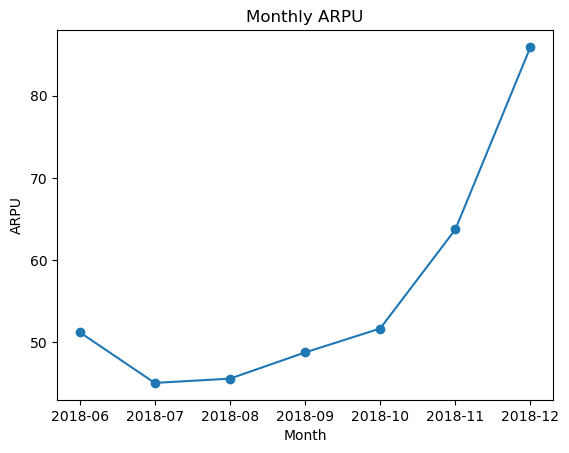

In [111]:
from matplotlib import pyplot as plt
# extract only year and month from 'month' column
monthly['month'] = pd.to_datetime(monthly['month'],utc=True)
monthly['month'] = monthly['month'].dt.strftime('%Y-%m')

# plot
plt.plot(monthly['month'], monthly['arpu'], marker='o')
plt.xlabel('Month')
plt.ylabel('ARPU')
plt.title('Monthly ARPU')

plt.show()

Despite dropping ARPU rates after the release of the app, the growth rate has accelerated since October 2018 and continues to grow.

Weekly ARPU 

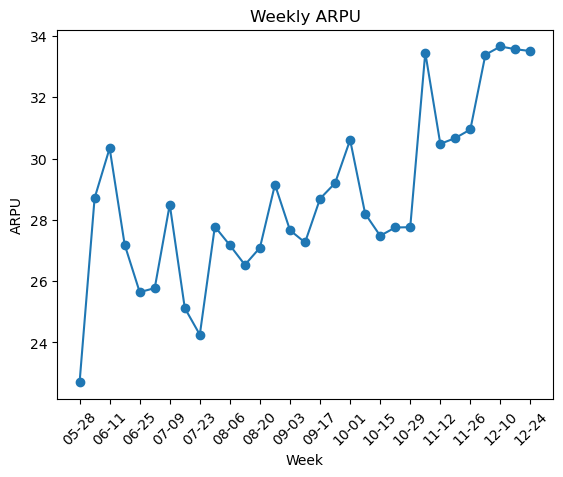

In [112]:
weekly['week'] = pd.to_datetime(weekly['week'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
weekly['week'] = weekly['week'].dt.strftime('%m-%d')
# plot
plt.plot(weekly['week'], weekly['arpu'], marker='o')
plt.xlabel('Week')
plt.ylabel('ARPU')
plt.title('Weekly ARPU')
plt.xticks(ticks = range(0, len(weekly['week']),2),rotation=45)
plt.show()

Although ARPU generally increases over time, the trend isn't constant, with a sharp increase from late October to November, and noticeable decreases in mid-June, July and September. Further analysis is needed to determine whether these fluctuations are seasonal or influenced by other factors.